# Notes

* Pole placement! 

* Reference: https://www.youtube.com/watch?v=FXSpHy8LvmY&list=PLn8PRpmsu08podBgFw66-IavqU2SqPg_w&index=2

* Other reference: https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/04.12-Interactive-PID-Control-Tuning-with-Ziegler--Nichols.ipynb

In [113]:
import numpy as np
import control.matlab as matlab
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

State space form:
* $\dot x = A \cdot x + B \cdot u$
* $y = C \cdot x + D \cdot u$

In [114]:
A = np.array([[0, 1], [2, -1]])
B = np.array([[1], [0]])
C = np.array([[1, 0]])
D = np.array([[0]])

sys = matlab.ss(A, B, C, D)

sys

<LinearIOSystem:sys[2054]:['u[0]']->['y[0]']>

Eigenvalues of $A$ are the poles of the system.

In [115]:
# find eigenvalues of A
eigvals, eigvecs = np.linalg.eig(A)

eigvals

array([ 1., -2.])

If we have at least one eigenvalue with positive real part, the system is unstable.

<img src="eigenvalues.png" width=500>

To solve that, we need a pole placement controller.

In [116]:
# desired eigenvalues (we corrected the 1 to -1 for establishing stability)
P = np.array([-2, -1])

# hard math to find eigenvalues of A - BK
K = matlab.place(A, B, P)
K

matrix([[2., 1.]])

now that we have K feedback, we can create the closed loop system:

$\dot x = (A - B \cdot K) \cdot x$

In [117]:
Acl = A - B @ K

eigvals, eigvecs = np.linalg.eig(Acl)

eigvals

array([-1., -2.])

In [118]:
syscl = matlab.ss(Acl, B, C, D)

syscl

<LinearIOSystem:sys[2055]:['u[0]']->['y[0]']>

Now we can compare both step responses

Note that, A open loop is unstable and Acl closed loop is stable.

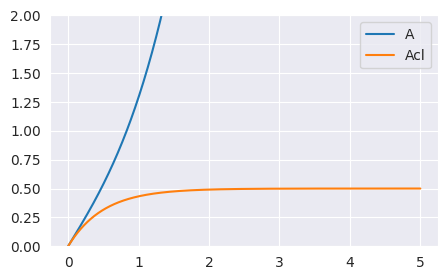

y(∞) = 98.44
ycl(∞) = 0.50


In [119]:
# step response of A and Acl
t = np.linspace(0, 5, 1000)
y, t = matlab.step(sys, t)
ycl, t = matlab.step(syscl, t)

fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(t, y, label='A')
ax.plot(t, ycl, label='Acl')
ax.legend()

# limit y axis
plt.ylim(0, 2)
plt.show()

# print "infinity" values of y and ycl
print(f'y(∞) = {y[-1]:.2f}')
print(f'ycl(∞) = {ycl[-1]:.2f}')

we also need to solve for the DC gain 

In [120]:
kdc = matlab.dcgain(syscl)
kr = 1/kdc 

kdc, kr

(0.5, 2.0)

In [121]:
syscl_scaled = matlab.ss(Acl, B*kr, C, D) # B*kr is the new B matrix

syscl_scaled

<LinearIOSystem:sys[2056]:['u[0]']->['y[0]']>

Agora podemos forçar a convergência do sistema para 1, por exemplo.

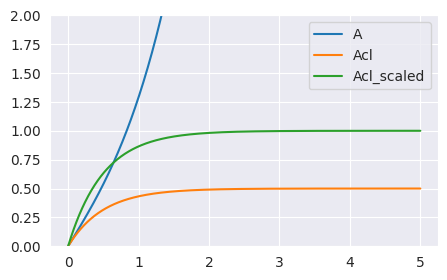

In [122]:
# step response of all systems

y_scaled, t = matlab.step(syscl_scaled, t)

fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(t, y, label='A')
ax.plot(t, ycl, label='Acl')
ax.plot(t, y_scaled, label='Acl_scaled')

ax.legend()
plt.ylim(0, 2)
plt.show()

# PD Controller compared to Pole Placement

Teorically we can use a PD controller to force the system to converge to 1, the same way a pole placement system would do. 

<img src="PD_controller.png" width=500>

In [123]:
# from tqdm import tqdm

# s = matlab.tf('s')
# t = np.linspace(0, 20, 1000)
# sys_tf = matlab.tf(sys)
# for p in tqdm(np.arange(9, 15, 0.1), desc='p loop', leave=False): 
#     for d in np.arange(9, 15, 0.1):
#         controller_tf = (p + d*s)
#         sys = matlab.ss(A, B, C, D)
#         closed_loop_sys = matlab.feedback(sys_tf*controller_tf, 1)
#         response, time = matlab.step(closed_loop_sys, t)
#         if response[-1] < 1.1 and response[-1] > 0.1:
#             print(f'kp = {kp}, kd = {kd}')
#             break

Poles: [-4.1038034+0.j         -0.9480983+0.56523585j -0.9480983-0.56523585j]
Controller: 
s^2 + 10 s + 10
---------------
       s

System: 
   s + 1
-----------
s^2 + s - 2

Closed-Loop System: 
 s^3 + 11 s^2 + 20 s + 10
--------------------------
2 s^3 + 12 s^2 + 18 s + 10

y(∞) = 1.00


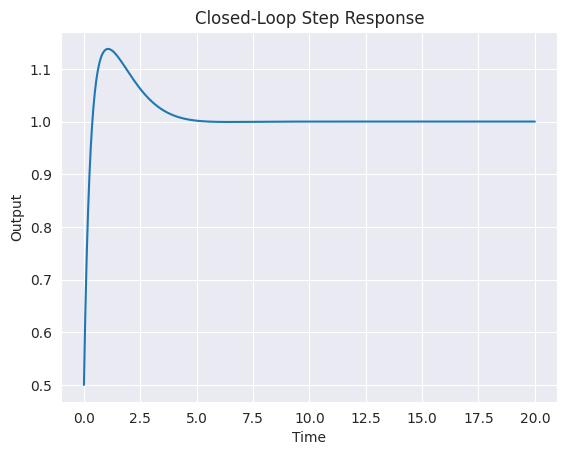

In [124]:
# Define PD controller gains (tune these values)
Kp = 10
Kd = 1
ki = 10

# Create the closed-loop transfer function by connecting the system and controller in feedback
s = matlab.tf('s')
controller_tf = (Kp + Kd*s + ki/s)
sys = matlab.ss(A, B, C, D)
sys_tf = matlab.tf(sys)
closed_loop_sys = matlab.feedback(sys_tf*controller_tf, 1)

print(f'Poles: {matlab.pole(closed_loop_sys)}')

# print tfs
print(f'Controller: {controller_tf}')
print(f'System: {sys_tf}')
print(f'Closed-Loop System: {closed_loop_sys}')

# Define time vector for simulation
t = np.linspace(0, 20, 1000)

# Step response of the closed-loop system
response, time = matlab.step(closed_loop_sys, t)

# steady-state value
print(f'y(∞) = {response[-1]:.2f}')

# Plot the step response
plt.plot(t, response)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Closed-Loop Step Response')
plt.grid(True)
plt.show()

## LQR 

LQR Controller: 
## LQR Control

LQR (Linear Quadratic Regulator) control is a type of optimal control that minimizes a quadratic cost function. The LQR controller is designed to stabilize a linear system by minimizing the cost function:

$$J = \int_{0}^{\infty} (x^T Q x + u^T R u) dt$$

where $x$ is the state vector, $u$ is the control input, $Q$ is the state weighting matrix, and $R$ is the control weighting matrix. The LQR controller computes the optimal control input $u^*$ that minimizes the cost function.

The LQR controller is designed to stabilize a linear system by minimizing the cost function. The LQR controller computes the optimal control input $u^*$ that minimizes the cost function. The optimal control input is given by:

$$u^* = -Kx$$

where $K$ is the LQR gain matrix. The LQR gain matrix is computed by solving the algebraic Riccati equation:

$$A^T P + P A - P B R^{-1} B^T P + Q = 0$$

where $P$ is the solution to the Riccati equation. The LQR gain matrix is then given by:

$$K = R^{-1} B^T P$$

The LQR controller is a state feedback controller, which means that the control input is a function of the state vector. The LQR controller is optimal in the sense that it minimizes the cost function and stabilizes the system.


In [125]:
# define the weighting matrices Q and R
Q = np.array([[5, 0], [0, 1]])
R = np.array([[5]])

# solve the algebraic Riccati equation to obtain the LQR gain matrix K
K, S, E = matlab.lqr(A, B, Q, R)

# create the closed-loop system with the LQR controller
Ac = A - B @ K
sys_lqr = matlab.ss(Ac, B, C, D)

# print the LQR gain matrix
print(f"LQR gain matrix: {K}")


LQR gain matrix: [[2.28886574 1.05972659]]


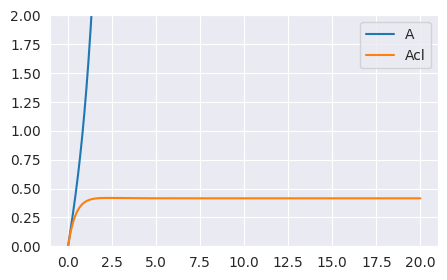

In [126]:
# plot 
t = np.linspace(0, 20, 1000)
y, t = matlab.step(sys, t)
ylqr, t = matlab.step(sys_lqr, t)

fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(t, y, label='A')
ax.plot(t, ylqr, label='Acl')
ax.legend()

# limit y axis
plt.ylim(0, 2)

plt.show()